In [1]:
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ


def load_config(config_path, display=False):
    config = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config)))
    return config


def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    if is_gumbel:
        model = GumbelVQ(**config.model.params)
    else:
        model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval()


def preprocess_vqgan(x):
    x = 2. * x - 1.
    return x


def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.) / 2.
    x = x.permute(1, 2, 0).numpy()
    x = (255 * x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x


def reconstruct_with_vqgan(x, model):
    # could also use model(x) for reconstruction but use explicit encoding and decoding here
    z, _, [_, _, indices] = model.encode(x)
    print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    xrec = model.decode(z)
    return xrec


import io
import os
import sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF


def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

/home/zhangxiaohong/public_user/miniconda3/envs/molvqgan/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
config = load_config("/home/public_space/zhangxiaohong/public_user/ChemMLLM/vqgan/configs/mol_vqgan.yaml", display=False)
model = load_vqgan(config, ckpt_path="/home/public_space/zhangxiaohong/public_user/ChemMLLM/vqgan/ckpt/vqgan_260115_e1_s173400_l01.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from ckpt/vqgan.ckpt


VQGAN --- VQModel: latent shape: torch.Size([16, 16])


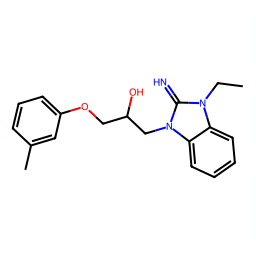

In [15]:
from PIL import Image
from IPython.display import display

image_path = "data/image/val/100000.png"
image = Image.open(image_path).convert("RGB")
image = image.resize((256, 256))

x = preprocess(image, target_image_size=256).to(DEVICE)
x = preprocess_vqgan(x)
xrec = reconstruct_with_vqgan(x, model)
xrec_pil = custom_to_pil(xrec[0])
display(xrec_pil)